Iota Calculation (Wendelstein 7-X)
==================================

This example shows how to calculate the rotational transform for Wendelstein 7-X. 

In [1]:
import fusionsc as fsc
from fusionsc.devices import w7x

First, we need to perform some setup to make sure W7-X data are available.

Note: The W7-X geometry is currently protected by the W7-X data access agreement. Therefore, the file referenced below is available to W7-X team members (including external collaborators who signed this agreement) upon request.

In [2]:
fsc.resolve.importOfflineData('../../w7x-op21.fsc')

Now we need to setup the geometry and magnetic field configuration. To speed up the magnetic field calculation, we use a slightly coarser grid.

In [3]:
field = w7x.standard()

grid = w7x.defaultGrid()
grid.nR = 128
grid.nZ = 128
grid.nPhi = 32

field = field.compute(grid)
await field

Finally, we need to decide in which phi planes we want to evaluate our Poincare plots, and which points to start our traces on.

In [4]:
import numpy as np
xStart = np.linspace(-4.5, -6.5, 30)
yStart = 0 * xStart
zStart = 0 * xStart

Now it's time to run our calculation.

In [ ]:
iotas = fsc.flt.calculateIota(field, [xStart, yStart, zStart], targetError = 1e-3, unwrapEvery = 10, distanceLimit = 1e4)

In [ ]:
# Shape is [5, nPlanes] + startsPoints.shape[1:] + [nTurns]
iotas.shape

In [ ]:
import matplotlib.pyplot as plt
plt.plot(xStart, iotas)

In [5]:
xyz = np.asarray([xStart, yStart, zStart])[:,15]

In [20]:
xP, yP, zP, lB, lF = fsc.flt.poincareInPhiPlanes(xyz, field, [0], 200000, targetError = 1e-3, distanceLimit = 0)

In [5]:
help(fsc.flt.poincareInPhiPlanes)

Help on AsyncMethodDescriptor in module fusionsc.flt:

poincareInPhiPlanes(points, config, phiPlanes, turnLimit, **kwArgs) -> Any
            Computes the Poincaré map starting from a given set of points on a config.
            
            Mostly equivalent to :code:`trace(points, config, phiPlanes = phiPlanes, turnLimit = turnLimit, **kwArgs)["poincareHits"]`.
            
            Parameters:
                    - points: Starting points for the trace. Can be any shape, but the first dimension must have a size of 3 (x, y, z).
                    - phiPlanes: 1D list of intersection plane angles (in radian)
                    - config: Magnetic configuration. If this is not yet computed, you also need to specify the 'grid' parameter (see the documentation of trace).
            
            Returns:
                    An array of shape [5, len(phiPlanes)] + points.shape[1:] + [turnLimit].
                    The entries in dimension 1 are [x, y, z, forward connection length, ba

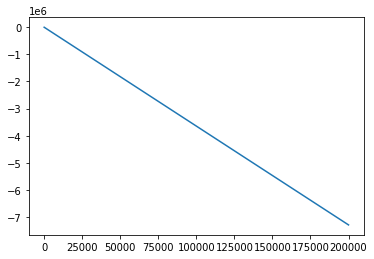

In [23]:
import matplotlib.pyplot as plt
plt.plot(lF.flatten())

In [21]:
lF.flatten()[-1] / 200000

-36.456602270777125

In [6]:
2 * np.pi * 6

37.69911184307752

In [8]:
axis = None
startPoints = xyz

In [9]:
distanceLimit = 1e4
unwrapEvery = 10
targetError = 1e-3
relativeErrorTolerance = 1
minStepSize = 1e-4
maxStepSize = 0.02

In [10]:
# Determine axis shape (required for phase unwrapping)
if axis is None:
    startPoint = startPoints.reshape([3, -1]).mean(axis = 1)
    _, axis = await fsc.flt.findAxis.asnc(field, startPoint = startPoint)

xAx, yAx, zAx = axis
rAx = np.sqrt(xAx**2 + yAx**2)

# Initialize trace request
request = fsc.flt.service.FLTRequest.newMessage()
request.stepSize = 0.001
request.startPoints = startPoints
request.field = field.data.computedField
request.distanceLimit = distanceLimit
request.recordEvery = 1
request.turnLimit = 1

calcIota = request.fieldLineAnalysis.initCalculateIota()
calcIota.unwrapEvery = unwrapEvery
calcIota.rAxis = rAx
calcIota.zAxis = zAx

adaptive = request.stepSizeControl.initAdaptive()
adaptive.targetError = targetError
adaptive.relativeTolerance = relativeErrorTolerance
adaptive.min = minStepSize
adaptive.max = maxStepSize

planes = request.initPlanes(200)
for i in range(200):
    planes[i].orientation.phi = i / 200 * 2 * np.pi

#errorEstimationDistance = 2 * 2 * np.pi * field.data.computedField.grid.rMax
adaptive.errorUnit.integratedOver = distanceLimit

# Perform trace command
response = await fsc.flt._tracer().trace(request)
#return np.asarray(response.iotas)

In [ ]:
x, y, z, _, _ = np.asarray(response.poincareHits).reshape([5, -1])
r = np.sqrt(x**2 + y**2)

In [9]:
rAx[100]

5.204638434385718

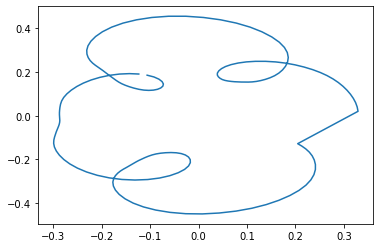

In [12]:
plt.plot(r - rAx, z - zAx)

(275,)


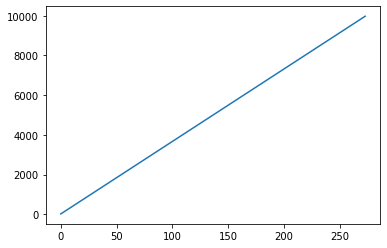

In [42]:
lB = -np.asarray(response.poincareHits).reshape([5, -1])[4]
print(lB.shape)
plt.plot(lB)

In [44]:
lB[-2] / (lB.size - 1) / (2 * np.pi)

5.793652847787024

In [45]:
xyz

array([-5.53448276, -0.        , -0.        ])

In [11]:
import matplotlib.pyplot as plt

In [11]:
import pyvista as pv

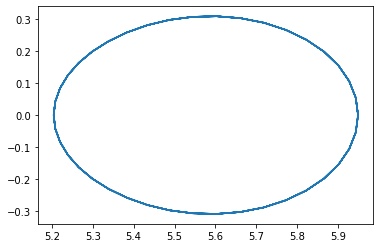

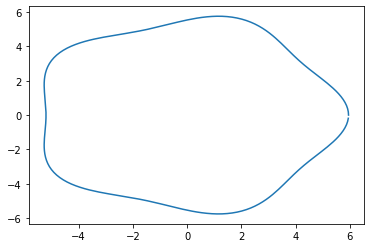

In [46]:
plt.plot(rAx, zAx)
plt.figure()
plt.plot(xAx, yAx)

In [10]:
xAx.shape

(200,)

In [39]:
x, y, z = np.asarray(response.fieldLines)[:, :1500]

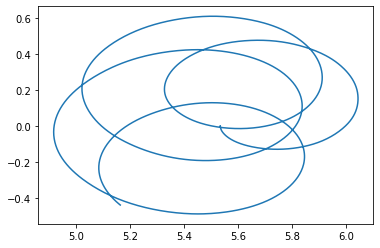

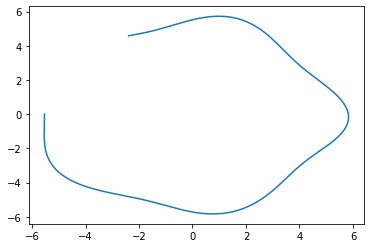

In [40]:
r = np.sqrt(x**2 + y**2)
plt.plot(r, z)
plt.figure()
plt.plot(x, y)

In [ ]:
plt.plot